In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Libraries that we'll use

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder
from sklearn.utils import shuffle



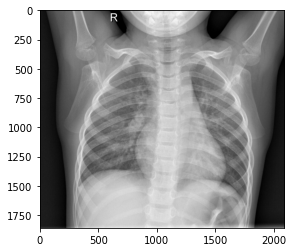

In [3]:
img=load_img('/content/gdrive/MyDrive/Colab Notebooks/Covid 19/chest_xray/train/NORMAL/IM-0115-0001.jpeg',color_mode="rgb")
plt.imshow(img)

In [4]:
TRAIN_PATH="/content/gdrive/MyDrive/Colab Notebooks/Covid 19/chest_xray/train"
TEST_PATH="/content/gdrive/MyDrive/Colab Notebooks/Covid 19/chest_xray/test"

In [5]:
class_names=["NORMAL","PNEUMONIA"]
class_names_labels={class_name:i for i, class_name in enumerate(class_names)}

In [6]:
class_names_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
def load_data():
  datasets=[TRAIN_PATH,TEST_PATH]
  output=[]

  for dataset in datasets:
    images=[]
    labels=[]
    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      label=class_names_labels[folder]
      
      for file in tqdm(os.listdir(os.path.join(dataset,folder))):
        img_path=os.path.join(os.path.join(dataset,folder),file)
        img=load_img(img_path,target_size=(224,224),color_mode="rgb")
        img=img_to_array(img)

        images.append(img)
        labels.append(label)
      
    images=np.array(images,dtype="float32")
    labels=np.array(labels,dtype="int32")
    
  
    output.append((images,labels))
  return output


In [8]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading /content/gdrive/MyDrive/Colab Notebooks/Covid 19/chest_xray/train


100%|██████████| 1341/1341 [01:07<00:00, 19.99it/s]


Loading /content/gdrive/MyDrive/Colab Notebooks/Covid 19/chest_xray/test


100%|██████████| 390/390 [00:06<00:00, 56.76it/s]


Data Scaling

In [ ]:
train_images=train_images/255.0
test_images=test_images/255.0

Shuffling the Dataset

In [ ]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=42)

In [ ]:
print("Train Images Shape : {}".format(train_images.shape))
print("Train Labels Shape : {}".format(train_labels.shape))
print("Test Images Shape : {}".format(test_images.shape))
print("Train Labels Shape : {}".format(test_labels.shape))

Train Images Shape : (5216, 224, 224, 3)
Train Labels Shape : (5216,)
Test Images Shape : (624, 224, 224, 3)
Train Labels Shape : (624,)


In [ ]:
print("Number of Pneumonia Samples : {}".format(len(train_labels[train_labels==1])))
print("Number of Non-Pneumonia Samples : {}".format(len(train_labels[train_labels==0])))

Number of Pneumonia Samples : 3875
Number of Non-Pneumonia Samples : 1341


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


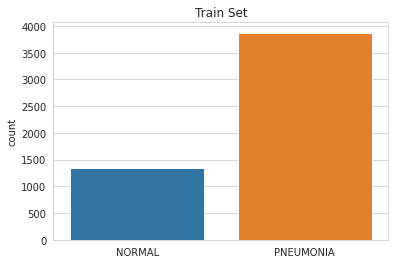

In [ ]:
sns.set_style("whitegrid");
sns.countplot(train_labels);
plt.xticks([0.0,1.0],["NORMAL","PNEUMONIA"]);
plt.title("Train Set");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


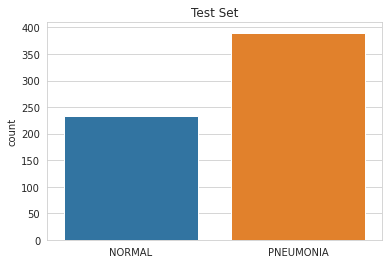

In [ ]:
sns.set_style("whitegrid");
sns.countplot(test_labels);
plt.xticks([0.0,1.0],["NORMAL","PNEUMONIA"]);
plt.title("Test Set");

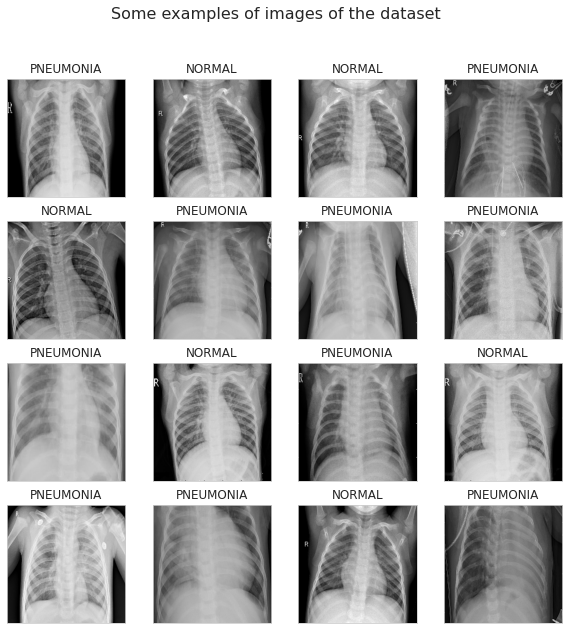

In [ ]:
def display_image(class_names,images,labels):
  fig=plt.figure(figsize=(10,10))
  fig.suptitle("Some examples of images of the dataset",fontsize=16)
  for i in range(1,17):
    plt.subplot(4,4,i)
    plt.xticks([]);
    plt.yticks([]);
    plt.grid(False)
    plt.imshow(images[i])
    plt.title(str(class_names[labels[i]]))
  
display_image(class_names,train_images,train_labels)
  



Data Augmentation

In [ ]:
datagen=ImageDataGenerator(rotation_range=30,
                       vertical_flip=True,
                       horizontal_flip=True,
                       width_shift_range=0.2,
                       height_shift_range=0.2,
                       fill_mode="nearest")

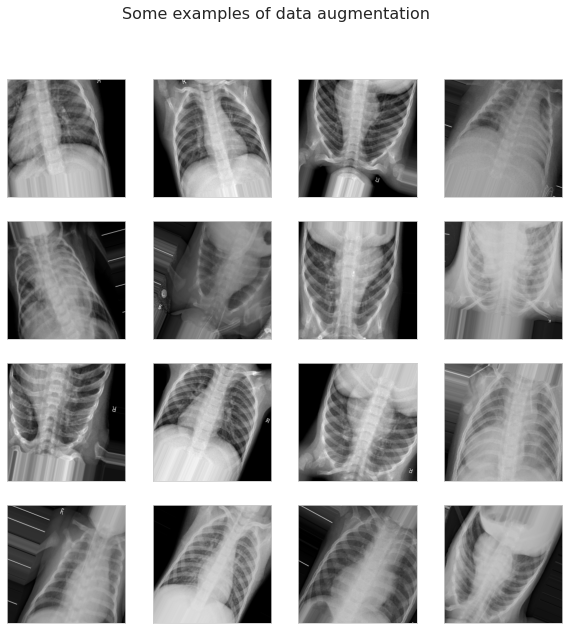

In [ ]:
samples=datagen.flow(train_images,batch_size=1)

fig=plt.figure(figsize=(10,10))
fig.suptitle("Some examples of data augmentation",fontsize=16)
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.xticks([]);
  plt.yticks([]);
  plt.grid(False)
  plt.imshow(samples[i][0])




  


In [ ]:
train_gen=datagen.flow(train_images,train_labels,batch_size=64)

Modelling

In [ ]:
from keras.engine.input_layer import Input

basemodel=MobileNetV2(weights="imagenet",input_tensor=Input(shape=(224,224,3)))

for layer in basemodel.layers:
    layer.trainable=False

basemodel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
headmodel=basemodel.layers[-14].output
headmodel=tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3))(headmodel)
headmodel=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(headmodel)
headmodel=tf.keras.layers.Flatten(name="flatten")(headmodel)
headmodel=tf.keras.layers.Dense(512,activation=tf.nn.relu)(headmodel)
headmodel=tf.keras.layers.Dropout(0.3)(headmodel)
headmodel=tf.keras.layers.Dense(512,activation=tf.nn.relu)(headmodel)
headmodel=tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)(headmodel)

model=tf.keras.models.Model(inputs=basemodel.input,outputs=headmodel)

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
history=model.fit(train_gen,batch_size=64,epochs=30,validation_data=(test_images,test_labels))

Epoch 1/30
82/82 [==============================] - 180s 2s/step - loss: 0.2060 - accuracy: 0.9210 - val_loss: 0.4264 - val_accuracy: 0.8285
Epoch 2/30
82/82 [==============================] - 185s 2s/step - loss: 0.1412 - accuracy: 0.9438 - val_loss: 0.5367 - val_accuracy: 0.8253
Epoch 3/30
82/82 [==============================] - 186s 2s/step - loss: 0.1548 - accuracy: 0.9404 - val_loss: 0.3245 - val_accuracy: 0.8526
Epoch 4/30
82/82 [==============================] - 189s 2s/step - loss: 0.1276 - accuracy: 0.9513 - val_loss: 0.3152 - val_accuracy: 0.8766
Epoch 5/30
82/82 [==============================] - 182s 2s/step - loss: 0.1173 - accuracy: 0.9559 - val_loss: 0.4286 - val_accuracy: 0.8301
Epoch 6/30
82/82 [==============================] - 188s 2s/step - loss: 0.1206 - accuracy: 0.9505 - val_loss: 0.4289 - val_accuracy: 0.8462
Epoch 7/30
82/82 [==============================] - 196s 2s/step - loss: 0.1038 - accuracy: 0.9586 - val_loss: 0.6933 - val_accuracy: 0.7821
Epoch 8/30
82

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


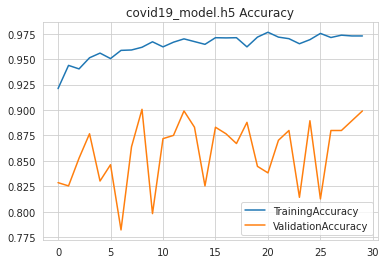

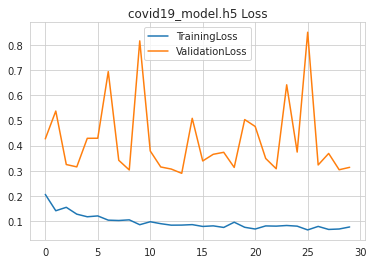

In [ ]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/Covid 19/covid19_model.h5")

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epoch=range(0,30)

plt.plot(epoch,acc,label="TrainingAccuracy")
plt.plot(epoch,val_acc,label="ValidationAccuracy")
plt.title("covid19_model.h5 Accuracy")

plt.legend()
plt.savefig('plot.png', dpi=300)
plt.show()

plt.plot(epoch,loss,label="TrainingLoss")
plt.plot(epoch,val_loss,label="ValidationLoss")
plt.title("covid19_model.h5 Loss")

plt.legend()
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Covid 19/plot2.png', dpi=300)
plt.show()